In [3]:
# Import Python Standard Library dependencies
from functools import partial
from pathlib import Path

# Import utility functions
from cjm_pil_utils.core import get_img_files
from cjm_psl_utils.core import download_file, file_extract
from cjm_pytorch_utils.core import tensor_to_pil
from cjm_torchvision_tfms.core import ResizeMax, PadSquare, CustomRandomIoUCrop

# Import the distinctipy module
from distinctipy import distinctipy

# Import matplotlib for creating plots
import matplotlib.pyplot as plt

# Import numpy
import numpy as np

# Import the pandas package
import pandas as pd

# Do not truncate the contents of cells and display all rows and columns
pd.set_option('max_colwidth', None, 'display.max_rows', None, 'display.max_columns', None)

# Import PIL for image manipulation
from PIL import Image, ImageDraw

# Import PyTorch dependencies
import torch
from torch.utils.data import Dataset, DataLoader

# Import torchvision dependencies
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.tv_tensors import BoundingBoxes, Mask
from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks
import torchvision.transforms.v2  as transforms

# Import tqdm for progress bar
from tqdm.auto import tqdm

In [4]:
# Define path to store datasets
dataset_dir = Path("DATASET TEBU")
# Create the dataset directory if it does not exist
dataset_dir.mkdir(parents=True, exist_ok=True)

# Define path to store archive files
archive_dir = dataset_dir/'../Archive'
# Create the archive directory if it does not exist
archive_dir.mkdir(parents=True, exist_ok=True)

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Dataset Directory:": dataset_dir, 
    "Archive Directory:": archive_dir
}).to_frame().style.hide(axis='columns')

Dataset Directory:,DATASET TEBU
Archive Directory:,DATASET TEBU\..\Archive


In [5]:
# Set the name of the dataset
dataset_name = 'coco-instance-segmentation-sugarcane-dataset'

# Construct the HuggingFace Hub dataset name by combining the username and dataset name
sc_dataset = f'cj-mills/{dataset_name}'

# Create the path to the zip file that contains the dataset
archive_path = Path(f'{archive_dir}/{dataset_name}.zip')

# Create the path to the directory where the dataset will be extracted
dataset_path = Path(f'{dataset_dir}/{dataset_name}')

# Creating a Series with the dataset name and paths and converting it to a DataFrame for display
pd.Series({
    "Sugarcane Dataset:": sc_dataset, 
    "Archive Path:": archive_path, 
    "Dataset Path:": dataset_path
}).to_frame().style.hide(axis='columns')

Sugarcane Dataset:,cj-mills/coco-instance-segmentation-sugarcane-dataset
Archive Path:,DATASET TEBU\..\Archive\coco-instance-segmentation-sugarcane-dataset.zip
Dataset Path:,DATASET TEBU\coco-instance-segmentation-sugarcane-dataset


In [15]:
 # Assuming the images are stored in a subfolder named 'images'
img_dir = "DATASET_TEBU"

# Assuming the annotation file is in JSON format and located in a subdirectory of the dataset
annotation_file_path = "DATASET_TEBU/CVAT Anot/annotations/instances_default.json"

# Creating a Series with the paths and converting it to a DataFrame for display
pd.Series({
    "Image Folder": img_dir,
    "Annotation File": annotation_file_path
}).to_frame().style.hide(axis='columns')

Image Folder,DATASET_TEBU
Annotation File,DATASET_TEBU/CVAT Anot/annotations/instances_default.json


In [16]:
# Get all image files in the 'img_dir' directory
img_dict = {
    file.stem : file # Create a dictionary that maps file names to file paths
    for file in get_img_files(img_dir) # Get a list of image files in the image directory
}

# Print the number of image files
print(f"Number of Images: {len(img_dict)}")

# Display the first five entries from the dictionary using a Pandas DataFrame
pd.DataFrame.from_dict(img_dict, orient='index').head

Number of Images: 400


<bound method NDFrame.head of                                     0
img_0_0      DATASET_TEBU\img_0_0.png
img_0_1      DATASET_TEBU\img_0_1.png
img_0_10    DATASET_TEBU\img_0_10.png
img_0_11    DATASET_TEBU\img_0_11.png
img_0_12    DATASET_TEBU\img_0_12.png
img_0_13    DATASET_TEBU\img_0_13.png
img_0_14    DATASET_TEBU\img_0_14.png
img_0_15    DATASET_TEBU\img_0_15.png
img_0_16    DATASET_TEBU\img_0_16.png
img_0_17    DATASET_TEBU\img_0_17.png
img_0_18    DATASET_TEBU\img_0_18.png
img_0_19    DATASET_TEBU\img_0_19.png
img_0_2      DATASET_TEBU\img_0_2.png
img_0_3      DATASET_TEBU\img_0_3.png
img_0_4      DATASET_TEBU\img_0_4.png
img_0_5      DATASET_TEBU\img_0_5.png
img_0_6      DATASET_TEBU\img_0_6.png
img_0_7      DATASET_TEBU\img_0_7.png
img_0_8      DATASET_TEBU\img_0_8.png
img_0_9      DATASET_TEBU\img_0_9.png
img_10_0    DATASET_TEBU\img_10_0.png
img_10_1    DATASET_TEBU\img_10_1.png
img_10_10  DATASET_TEBU\img_10_10.png
img_10_11  DATASET_TEBU\img_10_11.png
img_10_12  DATASET_T

In [17]:
# Read the JSON file into a DataFrame, assuming the JSON is oriented by index
annotation_file_df = pd.read_json(annotation_file_path, orient='index').transpose()
annotation_file_df.head()

,licenses,info,categories,images,annotations
0,"{'name': '', 'id': 0, 'url': ''}",contributor,"{'id': 1, 'name': 'tebu tumbuh', 'supercategory': ''}","{'id': 1, 'width': 524, 'height': 847, 'file_name': 'img_0_0.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 1, 'image_id': 62, 'category_id': 1, 'segmentation': [[376.09, 226.49, 445.95, 219.28, 422.97, 260.3, 426.12, 298.16, 435.59, 348.19, 415.75, 370.73, 394.12, 395.97, 375.19, 398.67, 375.19, 348.19, 381.5, 279.23, 378.79, 267.06]], 'area': 8388.0, 'bbox': [375.19, 219.28, 70.76, 179.39], 'iscrowd': 0, 'attributes': {'occluded': False}}"
1,None,date_created,"{'id': 2, 'name': 'tebu tidak tumbuh', 'supercategory': ''}","{'id': 2, 'width': 524, 'height': 847, 'file_name': 'img_0_1.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 2, 'image_id': 62, 'category_id': 1, 'segmentation': [[271.16, 0.72, 344.9, 0.0, 318.21, 329.57, 310.1, 690.34, 311.18, 844.49, 239.25, 846.11, 261.96, 321.46, 265.21, 174.88]], 'area': 53935.0, 'bbox': [239.25, 0.0, 105.65, 846.11], 'iscrowd': 0, 'attributes': {'occluded': False}}"
2,None,description,None,"{'id': 3, 'width': 524, 'height': 847, 'file_name': 'img_0_2.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 3, 'image_id': 62, 'category_id': 2, 'segmentation': [[376.5, 543.6, 398.1, 545.5, 405.2, 544.2, 388.12, 560.25, 380.03, 566.77, 376.64, 554.25]], 'area': 328.0, 'bbox': [376.5, 543.6, 28.7, 23.17], 'iscrowd': 0, 'attributes': {'occluded': False}}"
3,None,url,None,"{'id': 4, 'width': 524, 'height': 847, 'file_name': 'img_0_3.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 4, 'image_id': 62, 'category_id': 1, 'segmentation': [[379.93, 13.43, 442.67, 10.18, 451.0, 110.3, 449.4, 134.0, 386.96, 160.01, 377.77, 84.28, 378.31, 58.32]], 'area': 9150.0, 'bbox': [377.77, 10.18, 73.23, 149.83], 'iscrowd': 0, 'attributes': {'occluded': False}}"
4,None,version,None,"{'id': 5, 'width': 524, 'height': 847, 'file_name': 'img_0_4.png', 'license': 0, 'flickr_url': '', 'coco_url': '', 'date_captured': 0}","{'id': 5, 'image_id': 62, 'category_id': 2, 'segmentation': [[376.04, 401.06, 399.93, 396.1, 419.77, 368.61, 428.33, 390.69, 427.88, 408.72, 409.4, 410.07, 403.09, 411.43, 386.86, 414.13, 378.75, 418.19, 376.04, 418.64]], 'area': 1191.0, 'bbox': [376.04, 368.61, 52.29, 50.03], 'iscrowd': 0, 'attributes': {'occluded': False}}"


In [18]:
# Extract and transform the 'categories' section of the data
# This DataFrame contains category details like category ID and name
categories_df = annotation_file_df['categories'].dropna().apply(pd.Series)
categories_df.set_index('id', inplace=True)
categories_df

,name,supercategory
id,,
1,tebu tumbuh,
2,tebu tidak tumbuh,


In [23]:
# Extract and transform the 'images' section of the data
# This DataFrame contains image details like file name, height, width, and image ID
images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
images_df.head()

C:\Users\ASUS\AppData\Local\Temp\ipykernel_27208\482364569.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27208\482364569.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)[['file_name', 'height', 'width', 'id']]
C:\Users\ASUS\AppData\Local\Temp\ipykernel_27208\482364569.py:3: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  images_df = annotation_file_df['images'].to_frame()['images'].apply(pd.Series)

,file_name,height,width,id
0,img_0_0.png,847.0,524.0,1.0
1,img_0_1.png,847.0,524.0,2.0
2,img_0_2.png,847.0,524.0,3.0
3,img_0_3.png,847.0,524.0,4.0
4,img_0_4.png,847.0,524.0,5.0


In [24]:
# Extract and transform the 'annotations' section of the data
# This DataFrame contains annotation details like image ID, segmentation points, bounding box, and category ID
annotations_df = annotation_file_df['annotations'].to_frame()['annotations'].apply(pd.Series)[['image_id', 'segmentation', 'bbox', 'category_id']]
annotations_df.head()

,image_id,segmentation,bbox,category_id
0,62,"[[376.09, 226.49, 445.95, 219.28, 422.97, 260.3, 426.12, 298.16, 435.59, 348.19, 415.75, 370.73, 394.12, 395.97, 375.19, 398.67, 375.19, 348.19, 381.5, 279.23, 378.79, 267.06]]","[375.19, 219.28, 70.76, 179.39]",1
1,62,"[[271.16, 0.72, 344.9, 0.0, 318.21, 329.57, 310.1, 690.34, 311.18, 844.49, 239.25, 846.11, 261.96, 321.46, 265.21, 174.88]]","[239.25, 0.0, 105.65, 846.11]",1
2,62,"[[376.5, 543.6, 398.1, 545.5, 405.2, 544.2, 388.12, 560.25, 380.03, 566.77, 376.64, 554.25]]","[376.5, 543.6, 28.7, 23.17]",2
3,62,"[[379.93, 13.43, 442.67, 10.18, 451.0, 110.3, 449.4, 134.0, 386.96, 160.01, 377.77, 84.28, 378.31, 58.32]]","[377.77, 10.18, 73.23, 149.83]",1
4,62,"[[376.04, 401.06, 399.93, 396.1, 419.77, 368.61, 428.33, 390.69, 427.88, 408.72, 409.4, 410.07, 403.09, 411.43, 386.86, 414.13, 378.75, 418.19, 376.04, 418.64]]","[376.04, 368.61, 52.29, 50.03]",2


In [25]:
# Map 'category_id' in annotations DataFrame to category name using categories DataFrame
annotations_df['label'] = annotations_df['category_id'].apply(lambda x: categories_df.loc[x]['name'])
annotations_df.head()

,image_id,segmentation,bbox,category_id,label
0,62,"[[376.09, 226.49, 445.95, 219.28, 422.97, 260.3, 426.12, 298.16, 435.59, 348.19, 415.75, 370.73, 394.12, 395.97, 375.19, 398.67, 375.19, 348.19, 381.5, 279.23, 378.79, 267.06]]","[375.19, 219.28, 70.76, 179.39]",1,tebu tumbuh
1,62,"[[271.16, 0.72, 344.9, 0.0, 318.21, 329.57, 310.1, 690.34, 311.18, 844.49, 239.25, 846.11, 261.96, 321.46, 265.21, 174.88]]","[239.25, 0.0, 105.65, 846.11]",1,tebu tumbuh
2,62,"[[376.5, 543.6, 398.1, 545.5, 405.2, 544.2, 388.12, 560.25, 380.03, 566.77, 376.64, 554.25]]","[376.5, 543.6, 28.7, 23.17]",2,tebu tidak tumbuh
3,62,"[[379.93, 13.43, 442.67, 10.18, 451.0, 110.3, 449.4, 134.0, 386.96, 160.01, 377.77, 84.28, 378.31, 58.32]]","[377.77, 10.18, 73.23, 149.83]",1,tebu tumbuh
4,62,"[[376.04, 401.06, 399.93, 396.1, 419.77, 368.61, 428.33, 390.69, 427.88, 408.72, 409.4, 410.07, 403.09, 411.43, 386.86, 414.13, 378.75, 418.19, 376.04, 418.64]]","[376.04, 368.61, 52.29, 50.03]",2,tebu tidak tumbuh


In [26]:
# Merge annotations DataFrame with images DataFrame on their image ID
annotation_df = pd.merge(annotations_df, images_df, left_on='image_id', right_on='id')
annotation_df.head()

,image_id,segmentation,bbox,category_id,label,file_name,height,width,id
0,62,"[[376.09, 226.49, 445.95, 219.28, 422.97, 260.3, 426.12, 298.16, 435.59, 348.19, 415.75, 370.73, 394.12, 395.97, 375.19, 398.67, 375.19, 348.19, 381.5, 279.23, 378.79, 267.06]]","[375.19, 219.28, 70.76, 179.39]",1,tebu tumbuh,img_3_1.png,847.0,524.0,62.0
1,62,"[[271.16, 0.72, 344.9, 0.0, 318.21, 329.57, 310.1, 690.34, 311.18, 844.49, 239.25, 846.11, 261.96, 321.46, 265.21, 174.88]]","[239.25, 0.0, 105.65, 846.11]",1,tebu tumbuh,img_3_1.png,847.0,524.0,62.0
2,62,"[[376.5, 543.6, 398.1, 545.5, 405.2, 544.2, 388.12, 560.25, 380.03, 566.77, 376.64, 554.25]]","[376.5, 543.6, 28.7, 23.17]",2,tebu tidak tumbuh,img_3_1.png,847.0,524.0,62.0
3,62,"[[379.93, 13.43, 442.67, 10.18, 451.0, 110.3, 449.4, 134.0, 386.96, 160.01, 377.77, 84.28, 378.31, 58.32]]","[377.77, 10.18, 73.23, 149.83]",1,tebu tumbuh,img_3_1.png,847.0,524.0,62.0
4,62,"[[376.04, 401.06, 399.93, 396.1, 419.77, 368.61, 428.33, 390.69, 427.88, 408.72, 409.4, 410.07, 403.09, 411.43, 386.86, 414.13, 378.75, 418.19, 376.04, 418.64]]","[376.04, 368.61, 52.29, 50.03]",2,tebu tidak tumbuh,img_3_1.png,847.0,524.0,62.0


In [27]:
# Remove old 'id' column post-merge
annotation_df.drop('id', axis=1, inplace=True)

# Extract the image_id from the file_name (assuming file_name contains the image_id)
annotation_df['image_id'] = annotation_df['file_name'].apply(lambda x: x.split('.')[0])

# Set 'image_id' as the index for the DataFrame
annotation_df.set_index('image_id', inplace=True)
annotation_df.head()

,segmentation,bbox,category_id,label,file_name,height,width
image_id,,,,,,,
img_3_1,"[[376.09, 226.49, 445.95, 219.28, 422.97, 260.3, 426.12, 298.16, 435.59, 348.19, 415.75, 370.73, 394.12, 395.97, 375.19, 398.67, 375.19, 348.19, 381.5, 279.23, 378.79, 267.06]]","[375.19, 219.28, 70.76, 179.39]",1,tebu tumbuh,img_3_1.png,847.0,524.0
img_3_1,"[[271.16, 0.72, 344.9, 0.0, 318.21, 329.57, 310.1, 690.34, 311.18, 844.49, 239.25, 846.11, 261.96, 321.46, 265.21, 174.88]]","[239.25, 0.0, 105.65, 846.11]",1,tebu tumbuh,img_3_1.png,847.0,524.0
img_3_1,"[[376.5, 543.6, 398.1, 545.5, 405.2, 544.2, 388.12, 560.25, 380.03, 566.77, 376.64, 554.25]]","[376.5, 543.6, 28.7, 23.17]",2,tebu tidak tumbuh,img_3_1.png,847.0,524.0
img_3_1,"[[379.93, 13.43, 442.67, 10.18, 451.0, 110.3, 449.4, 134.0, 386.96, 160.01, 377.77, 84.28, 378.31, 58.32]]","[377.77, 10.18, 73.23, 149.83]",1,tebu tumbuh,img_3_1.png,847.0,524.0
img_3_1,"[[376.04, 401.06, 399.93, 396.1, 419.77, 368.61, 428.33, 390.69, 427.88, 408.72, 409.4, 410.07, 403.09, 411.43, 386.86, 414.13, 378.75, 418.19, 376.04, 418.64]]","[376.04, 368.61, 52.29, 50.03]",2,tebu tidak tumbuh,img_3_1.png,847.0,524.0


In [28]:
# Group the data by 'image_id' and aggregate information
annotation_df = annotation_df.groupby('image_id').agg({
    'segmentation': list,
    'bbox': list, 
    'category_id': list,
    'label' :list,
    'file_name': 'first', 
    'height': 'first', 
    'width': 'first'
})

# Rename columns for clarity 
# 'bbox' is renamed to 'bboxes' and 'label' to 'labels'
annotation_df.rename(columns={'bbox': 'bboxes', 'label': 'labels'}, inplace=True)
annotation_df.head()

,segmentation,bboxes,category_id,labels,file_name,height,width
image_id,,,,,,,
img_10_1,"[[[239.5, 475.99, 317.33, 480.29, 313.89, 582.63, 238.64, 581.77]], [[247.74, 0.15, 282.47, 0.0, 333.37, 0.0, 319.76, 433.35, 233.41, 431.2]], [[144.6, 0.0, 219.6, 0.0, 198.61, 847.0, 121.97, 847.0]], [[6.91, 1.46, 105.5, 1.5, 75.8, 846.0, 37.71, 847.0, 0.6900000000000001, 847.0]], [[239.2, 582.64, 314.08, 583.36, 313.24, 642.04, 240.76, 642.64, 239.32, 642.64]], [[234.57, 431.56, 319.94, 433.98, 317.52, 479.95, 233.19, 475.11]], [[400.03, 46.73, 460.94, 46.73, 460.94, 127.35, 395.73, 126.99]], [[245.2, 643.3, 313.67, 642.97, 312.96, 847.0, 241.3, 847.0]], [[414.59, 0.0, 466.36, 0.28, 461.32, 46.12, 397.72, 45.76, 400.0, 0.0]], [[390.3, 846.3, 459.6, 844.4, 461.4, 127.8, 395.71, 128.23]]]","[[238.64, 475.99, 78.69, 106.64], [233.41, 0.0, 99.96, 433.35], [121.97, 0.0, 97.63, 847.0], [0.6900000000000001, 1.46, 104.81, 845.54], [239.2, 582.64, 74.88, 60.0], [233.19, 431.56, 86.75, 48.39], [395.73, 46.73, 65.21, 80.62], [241.3, 642.97, 72.37, 204.03], [397.72, 0.0, 68.64, 46.12], [390.3, 127.8, 71.1, 718.5]]","[1, 1, 1, 1, 2, 2, 2, 1, 1, 1]","[tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tidak tumbuh, tebu tidak tumbuh, tebu tidak tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh]",img_10_1.png,847.0,524.0
img_10_2,"[[[123.34, 230.38, 189.07, 227.26, 172.17, 790.98, 103.62, 791.3]], [[383.6, 0.9, 443.4, 0.0, 451.6, 0.0, 429.73, 847.0, 350.79, 847.0]], [[262.0, 0.30000000000000004, 336.6, 0.6000000000000001, 310.16, 847.0, 234.68, 847.0]], [[0.9500000000000001, 0.32, 66.68, 0.64, 52.91, 847.0, 0.32, 847.0]], [[126.32, 1.9100000000000001, 205.19, 1.9100000000000001, 186.71, 224.58, 124.51, 228.63]], [[104.71, 792.81, 169.92, 793.07, 169.15, 847.0, 114.6, 847.0, 101.84, 846.8]]]","[[103.62, 227.26, 85.45, 564.04], [350.79, 0.0, 100.81, 847.0], [234.68, 0.30000000000000004, 101.92, 846.7], [0.32, 0.32, 66.36, 846.68], [124.51, 1.9100000000000001, 80.68, 226.72], [101.84, 792.81, 68.08, 54.19]]","[1, 1, 1, 1, 2, 2]","[tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tidak tumbuh, tebu tidak tumbuh]",img_10_2.png,847.0,524.0
img_10_3,"[[[358.1, 686.7, 409.96, 685.68, 406.5, 847.0, 354.35, 847.0]], [[473.87, 0.4, 519.89, 0.0, 523.55, 0.0, 524.0, 44.75, 524.0, 57.56, 474.59, 55.26]], [[476.89, 56.09, 524.0, 57.64, 524.0, 376.99, 523.95, 384.4, 482.84, 383.32]], [[482.8, 383.11, 524.0, 383.78, 524.0, 847.0, 475.8, 847.0]], [[357.07, 635.96, 404.9, 635.74, 405.76, 684.86, 357.29, 685.95]], [[355.9, 375.62, 417.0, 375.3, 405.04, 633.54, 355.59, 634.48]], [[389.8, 0.0, 423.82, 0.32, 414.6, 374.4, 357.2, 374.1, 363.6, 0.30000000000000004]], [[163.61, 0.0, 149.71, 847.0, 79.94, 847.0, 94.06, 0.0]], [[0.32, 0.32, 53.2, 0.6000000000000001, 41.0, 847.0, 0.01, 847.0]], [[221.51, 0.16, 293.06, 0.34, 274.8, 756.3, 209.74, 756.05]], [[209.92, 756.38, 274.91, 756.6, 274.04, 847.0, 209.27, 847.0]]]","[[354.35, 685.68, 55.61, 161.32], [473.87, 0.0, 50.13, 57.56], [476.89, 56.09, 47.11, 328.31], [475.8, 383.11, 48.2, 463.89], [357.07, 635.74, 48.69, 50.21], [355.59, 375.3, 61.41, 259.18], [357.2, 0.0, 66.62, 374.4], [79.94, 0.0, 83.67, 847.0], [0.01, 0.32, 53.19, 846.68], [209.74, 0.16, 83.32, 756.14], [209.27, 756.38, 65.64, 90.62]]","[1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2]","[tebu tumbuh, tebu tidak tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tidak tumbuh]",img_10_3.png,847.0,524.0
img_10_4,"[[[76.23, 381.93, 158.3, 383.9, 133.99, 846.65, 60.0, 846.65]], [[471.5, 0.30000000000000004, 523.53, 0.19, 523.98, 847.0, 446.27, 847.0]], [[76.7, 135.57, 148.8, 136.3, 148.9, 206.0, 77.07, 208.39]], [[248.05, 0.0, 282.55, 0.34, 265.17, 847.0, 197.8, 847.0, 227.12, 0.0]], [[415.19, 0.0, 394.91, 847.0, 334.29, 847.0, 349.8, 0.0]], [[74.71, 0.37, 150.79, 0.37, 148.4, 135.79, 76.45, 134.71]], [[77.92, 209.08, 149.7, 208.1, 154.54, 383.52, 75.22, 380.81]]]","[[60.0, 381.93, 98.3, 464.72], [446.27, 0.

In [29]:
# Get a list of unique labels in the 'annotation_df' DataFrame
class_names = annotation_df['labels'].explode().unique().tolist()

# Display labels using a Pandas DataFrame
pd.DataFrame(class_names)

,0
0,tebu tumbuh
1,tebu tidak tumbuh


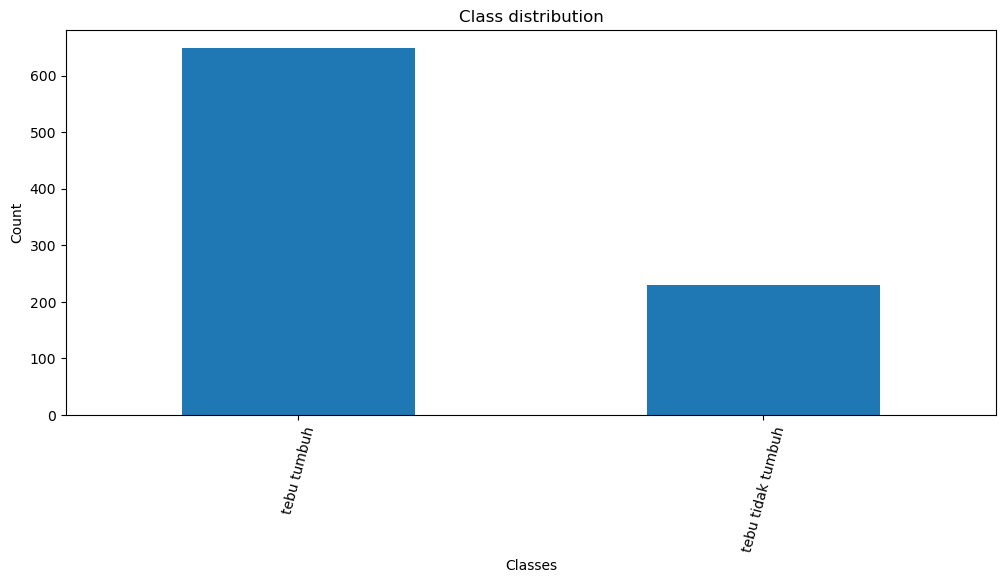

In [30]:
# Get the number of samples for each object class
class_counts = pd.DataFrame(annotation_df['labels'].explode().tolist()).value_counts()#.sort_index()

plot_labels = [index[0] for index in class_counts.index]

# Plot the distribution
class_counts.plot(kind='bar', figsize=(12, 5))
plt.title('Class distribution')
plt.ylabel('Count')
plt.xlabel('Classes')
plt.xticks(range(len(class_counts.index)), plot_labels, rotation=75)  # Set the x-axis tick labels
plt.show()

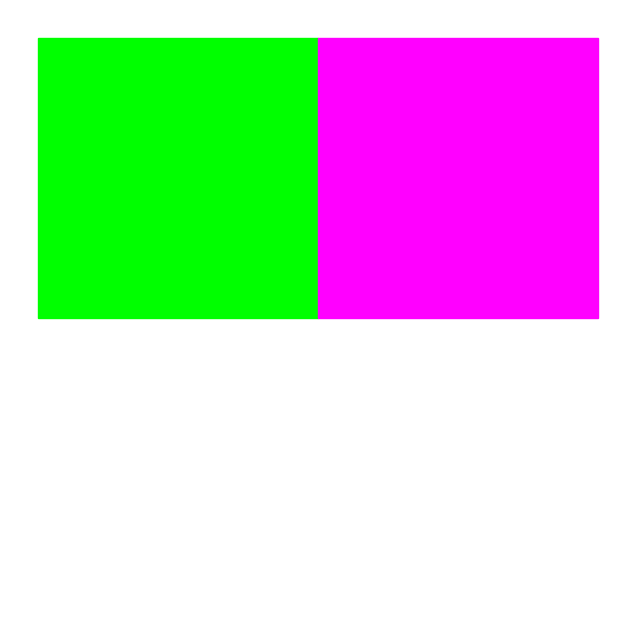

In [31]:
# Generate a list of colors with a length equal to the number of labels
colors = distinctipy.get_colors(len(class_names))

# Make a copy of the color map in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colors]

# Generate a color swatch to visualize the color map
distinctipy.color_swatch(colors)

In [32]:
# Set the name of the font file
font_file = 'KFOlCnqEu92Fr1MmEU9vAw.ttf'

# Download the font file
download_file(f"https://fonts.gstatic.com/s/roboto/v30/{font_file}", "./")

  0%|          | 0.00/130k [00:00<?, ?iB/s]

In [33]:
draw_bboxes = partial(draw_bounding_boxes, fill=False, width=2, font=font_file, font_size=25)

Image Dims: (524, 847)


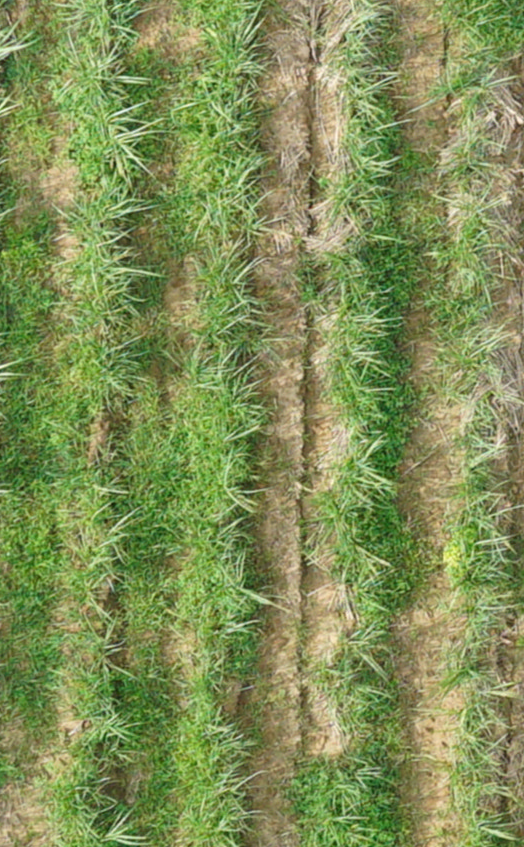

In [63]:
# Get the file ID of the first image file
file_id = list(img_dict.keys())[0]

# Open the associated image file as a RGB image
sample_img = Image.open(img_dict['img_10_5']).convert('RGB')

# Print the dimensions of the image
print(f"Image Dims: {sample_img.size}")

# Show the image
sample_img

In [57]:
# Get the row from the 'annotation_df' DataFrame corresponding to the 'file_id'
annotation_df.loc['img_10_5'].to_frame()

,img_10_5
segmentation,"[[[448.4, 516.5, 523.3, 516.1, 524.0, 599.94, 511.52, 846.87, 450.68, 846.87]], [[71.67, 405.11, 133.62, 405.11, 132.1, 464.23, 72.6, 464.2]], [[72.87, 465.94, 131.14, 466.85, 123.6, 599.1, 68.0, 598.2]], [[67.7, 599.2, 123.98, 599.65, 121.6, 634.7, 68.0, 634.5]], [[67.0, 635.1, 121.81, 635.88, 112.97, 847.0, 65.3, 847.0]], [[68.6, 0.5, 139.2, 1.1, 133.45, 403.89, 71.25, 403.89]], [[189.05, 0.59, 267.3, 0.59, 243.4, 847.0, 166.45, 847.0]], [[350.4, 0.0, 399.29, 1.3, 391.64, 847.0, 320.69, 847.0, 308.7, 846.87, 331.22, 0.0]], [[454.62, 79.47, 524.0, 81.22, 524.0, 478.73, 523.42, 507.85, 446.84, 507.85]]]"
bboxes,"[[448.4, 516.1, 75.6, 330.77], [71.67, 405.11, 61.95, 59.12], [68.0, 465.94, 63.14, 133.16], [67.7, 599.2, 56.28, 35.5], [65.3, 635.1, 56.51, 211.9], [68.6, 0.5, 70.6, 403.39], [166.45, 0.59, 100.85, 846.41], [308.7, 0.0, 90.59, 847.0], [446.84, 79.47, 77.16, 428.38]]"
category_id,"[1, 2, 1, 2, 1, 1, 1, 1, 2]"
labels,"[tebu tumbuh, tebu tidak tumbuh, tebu tumbuh, tebu tidak tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tumbuh, tebu tidak tumbuh]"
file_name,img_10_5.png
height,847.0
width,524.0


In [59]:
def create_polygon_mask(image_size, vertices):
    """
    Create a grayscale image with a white polygonal area on a black background.

    Parameters:
    - image_size (tuple): A tuple representing the dimensions (width, height) of the image.
    - vertices (list): A list of tuples, each containing the x, y coordinates of a vertex
                        of the polygon. Vertices should be in clockwise or counter-clockwise order.

    Returns:
    - PIL.Image.Image: A PIL Image object containing the polygonal mask.
    """

    # Create a new black image with the given dimensions
    mask_img = Image.new('L', image_size, 0)
    
    # Draw the polygon on the image. The area inside the polygon will be white (255).
    ImageDraw.Draw(mask_img, 'L').polygon(vertices, fill=(255))

    # Return the image with the drawn polygon
    return mask_img

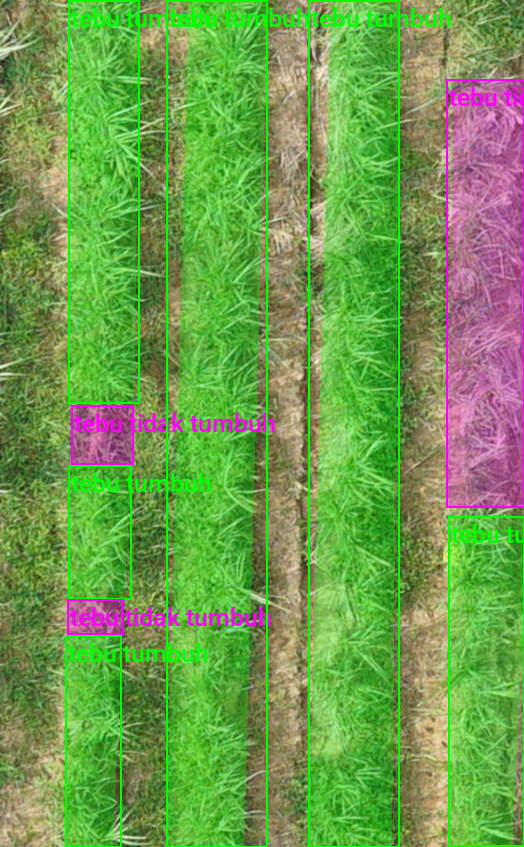

In [64]:
# Extract the polygon points for segmentation mask
# polygon_points = annotation_df.loc[file_id]['segmentation']
polygon_points = annotation_df.loc['img_10_5']['segmentation']

# Generate mask images from polygons
mask_imgs = [create_polygon_mask(sample_img.size, polygon[0]) for polygon in polygon_points]

# Convert mask images to tensors
masks = torch.concat([Mask(transforms.PILToTensor()(mask_img), dtype=torch.bool) for mask_img in mask_imgs])

# Extract the labels and bounding box annotations for the sample image
labels = annotation_df.loc['img_10_5']['labels']
bboxes = annotation_df.loc['img_10_5']['bboxes']

# Annotate the sample image with segmentation masks
annotated_tensor = draw_segmentation_masks(
    image=transforms.PILToTensor()(sample_img), 
    masks=masks, 
    alpha=0.3, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

# Annotate the sample image with labels and bounding boxes
annotated_tensor = draw_bboxes(
    image=annotated_tensor, 
    boxes=torchvision.ops.box_convert(torch.Tensor(bboxes), 'xywh', 'xyxy'),
    labels=labels, 
    colors=[int_colors[i] for i in [class_names.index(label) for label in labels]]
)

tensor_to_pil(annotated_tensor)

In [51]:
file_id in annotation_df

False